In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
import keras.layers as layers
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import confusion_matrix

2024-05-25 16:17:16.577380: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 16:17:17.146748: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DataSolarModules = pd.read_json('InfraredSolarModules/module_metadata.json').transpose().sort_index()
Classes = DataSolarModules['anomaly_class'].unique()
class_to_number = dict(enumerate(Classes.flatten(), 0))
class_to_number = {v: k for k, v in class_to_number.items()}

In [3]:
def map_to_class(value):
    class_to_number
    return class_to_number.get(value, 'Unknown')

DataSolarModules['class_code'] = DataSolarModules['anomaly_class'].apply(map_to_class)

In [4]:
def read_images_dataframe(dataframe):
    images = []
    for image_path in dataframe['image_filepath']:
        img = cv2.imread("InfraredSolarModules/"+image_path,cv2.IMREAD_GRAYSCALE)
        img = img.reshape(40, 24).astype("float32") / 255
        images.append(img)
    images=np.array(images) 
    return images

def read_labels_dataframe(dataframe):
    labels = []
    for label in dataframe['class_code']:
        labels.append(label)
    labels=np.array(labels) 
    labels.astype("int32")   
    return labels

In [5]:
images = read_images_dataframe(DataSolarModules)
labels = read_labels_dataframe(DataSolarModules)

In [6]:
# Function to apply geometric transformations
def apply_geometric_transformations(images, labels):
    flipped_images = []
    flipped_labels = []

    for i in range(len(images)):
        original_image = images[i]
        original_label = labels[i]

        # Append original image and label
        flipped_images.append(original_image)
        flipped_labels.append(original_label)

        # Flip vertically
        flipped_vertically = cv2.flip(original_image, 0)
        flipped_images.append(flipped_vertically)
        flipped_labels.append(original_label)

        # Flip horizontally
        flipped_horizontally = cv2.flip(original_image, 1)
        flipped_images.append(flipped_horizontally)
        flipped_labels.append(original_label)

        # Flip both vertically and horizontally
        flipped_both = cv2.flip(original_image, -1)
        flipped_images.append(flipped_both)
        flipped_labels.append(original_label)

    flipped_images = np.array(flipped_images)
    flipped_labels = np.array(flipped_labels)
    return flipped_images, flipped_labels

# Apply geometric transformations
images_GT, labels_GT = apply_geometric_transformations(images, labels)

In [10]:
images = images_GT
labels = labels_GT

In [11]:
# Create a testing set with 25 images per class
num_images_per_class = 25

def create_testing_set(dataframe, num_images_per_class):
    test_indices = []
    for cls in dataframe['class_code'].unique():
        class_indices = dataframe[dataframe['class_code'] == cls].index[:num_images_per_class].tolist()
        test_indices.extend(class_indices)
    return test_indices

test_indices = create_testing_set(DataSolarModules, num_images_per_class)
data_test = np.array(test_indices)
data_train = np.setdiff1d(np.arange(len(images)), data_test)

In [12]:
inputs = keras.Input(shape=(40, 24, 1))


x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)

x = layers.Dense(2048, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(128, activation="relu")(x)


outputs = layers.Dense(12, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

2024-05-25 16:49:40.497870: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 16:49:40.530247: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 16:49:40.530671: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40, 24, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 38, 22, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386,956 (16.73 MB)

 Trainable params: 4,386,956 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
batch_size = 64
n_epochs = 25

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

rkf = RepeatedKFold(n_splits=6, n_repeats=3, random_state=21312312)
datos = list(range(0,len(images)))


model.compile(optimizer=optimizer,                                    
              loss="sparse_categorical_crossentropy",                 
              metrics=["accuracy"])   

In [14]:
fold_no = 1
acc_per_fold = []
loss_per_fold = []

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train, val in rkf.split(data_train):

    history_model = model.fit(images[train], labels[train],
                              epochs=n_epochs,
                              validation_data=(images[val], labels[val]),
                              batch_size=batch_size)

    # Store metrics for this fold
    fold_train_loss = np.mean(history_model.history['loss'])
    fold_train_accuracy = np.mean(history_model.history['accuracy'])
    fold_val_loss = np.mean(history_model.history['val_loss'])
    fold_val_accuracy = np.mean(history_model.history['val_accuracy'])

    all_train_losses.append(fold_train_loss)
    all_train_accuracies.append(fold_train_accuracy)
    all_val_losses.append(fold_val_loss)
    all_val_accuracies.append(fold_val_accuracy)

    # Generate generalization metrics for the last epoch
    scores = model.evaluate(images[val], labels[val],verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

Epoch 1/25


I0000 00:00:1716626986.672325  233405 service.cc:145] XLA service 0x7404b0013200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716626986.672346  233405 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-05-25 16:49:46.707468: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-25 16:49:46.887031: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 110/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4729 - loss: 1.9267

I0000 00:00:1716626991.073745  233405 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5124 - loss: 1.7006

I0000 00:00:1716626996.401020  233406 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716626997.142544  233630 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716626997.154251  233644 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716626997.557362  233649 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 308 bytes spill stores, 308 bytes spill loads

I0000 00:00:1716626999.564103  233758 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 264 bytes spill stores, 264 bytes spill loads

I0000 00:00:1716626999.767913  233

1038/1038 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5125 - loss: 1.7005 - val_accuracy: 0.6341 - val_loss: 1.1716
Epoch 2/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6377 - loss: 1.1746 - val_accuracy: 0.6807 - val_loss: 1.0299
Epoch 3/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6739 - loss: 1.0331 - val_accuracy: 0.6993 - val_loss: 0.9535
Epoch 4/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6926 - loss: 0.9742 - val_accuracy: 0.7038 - val_loss: 0.9332
Epoch 5/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7075 - loss: 0.9221 - val_accuracy: 0.7244 - val_loss: 0.8696
Epoch 6/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7203 - loss: 0.8823 - val_accuracy: 0.7422 - val_loss: 0.7973
Epoch 7/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7309 - loss: 0.8457 - val_accuracy: 0.7430 - val_loss: 0.8027
Epoch 8/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7393 - loss: 0.8067 - val_accura

I0000 00:00:1716627037.012520  235257 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716627037.563711  235251 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716627037.619972  235246 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1716627038.862051  235385 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 4 bytes spill stores, 4 bytes spill loads



Score for fold 1: loss of 0.6102164387702942; compile_metrics of 79.94579672813416%
Epoch 1/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8086 - loss: 0.5857 - val_accuracy: 0.8353 - val_loss: 0.5005
Epoch 2/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8081 - loss: 0.5767 - val_accuracy: 0.8298 - val_loss: 0.4983
Epoch 3/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8110 - loss: 0.5724 - val_accuracy: 0.8407 - val_loss: 0.4760
Epoch 4/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8164 - loss: 0.5515 - val_accuracy: 0.8327 - val_loss: 0.5086
Epoch 5/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8212 - loss: 0.5480 - val_accuracy: 0.8306 - val_loss: 0.5039
Epoch 6/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8210 - loss: 0.5384 - val_accuracy: 0.8387 - val_loss: 0.4794
Epoch 7/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8234 - loss: 0.5344 - val_accuracy: 0.8385 - val_loss: 0.4802
Epoch 

I0000 00:00:1716627083.824884  233404 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716627084.738514  237043 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1716627085.133499  237029 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 284 bytes spill stores, 284 bytes spill loads

I0000 00:00:1716627085.417128  237037 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 264 bytes spill stores, 264 bytes spill loads



1038/1038 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8429 - loss: 0.4842 - val_accuracy: 0.8934 - val_loss: 0.3255
Epoch 2/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8417 - loss: 0.4758 - val_accuracy: 0.8947 - val_loss: 0.3260
Epoch 3/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8486 - loss: 0.4540 - val_accuracy: 0.8782 - val_loss: 0.3600
Epoch 4/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8488 - loss: 0.4550 - val_accuracy: 0.8923 - val_loss: 0.3266
Epoch 5/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8525 - loss: 0.4474 - val_accuracy: 0.8826 - val_loss: 0.3466
Epoch 6/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8518 - loss: 0.4438 - val_accuracy: 0.8874 - val_loss: 0.3314
Epoch 7/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8591 - loss: 0.4273 - val_accuracy: 0.8843 - val_loss: 0.3464
Epoch 8/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8583 - loss: 0.4282 - val_accurac

I0000 00:00:1716627122.859264  238546 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 4 bytes spill stores, 4 bytes spill loads



Score for fold 3: loss of 0.3827764391899109; compile_metrics of 87.07370162010193%
Epoch 1/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8690 - loss: 0.4058 - val_accuracy: 0.9234 - val_loss: 0.2297
Epoch 2/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8691 - loss: 0.3989 - val_accuracy: 0.9205 - val_loss: 0.2342
Epoch 3/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8716 - loss: 0.3892 - val_accuracy: 0.9167 - val_loss: 0.2419
Epoch 4/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8732 - loss: 0.3844 - val_accuracy: 0.9146 - val_loss: 0.2510
Epoch 5/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8735 - loss: 0.3833 - val_accuracy: 0.9129 - val_loss: 0.2547
Epoch 6/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8745 - loss: 0.3838 - val_accuracy: 0.9121 - val_loss: 0.2532
Epoch 7/25
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8760 - loss: 0.3748 - val_accuracy: 0.9035 - val_loss: 0.2655
Epoch 

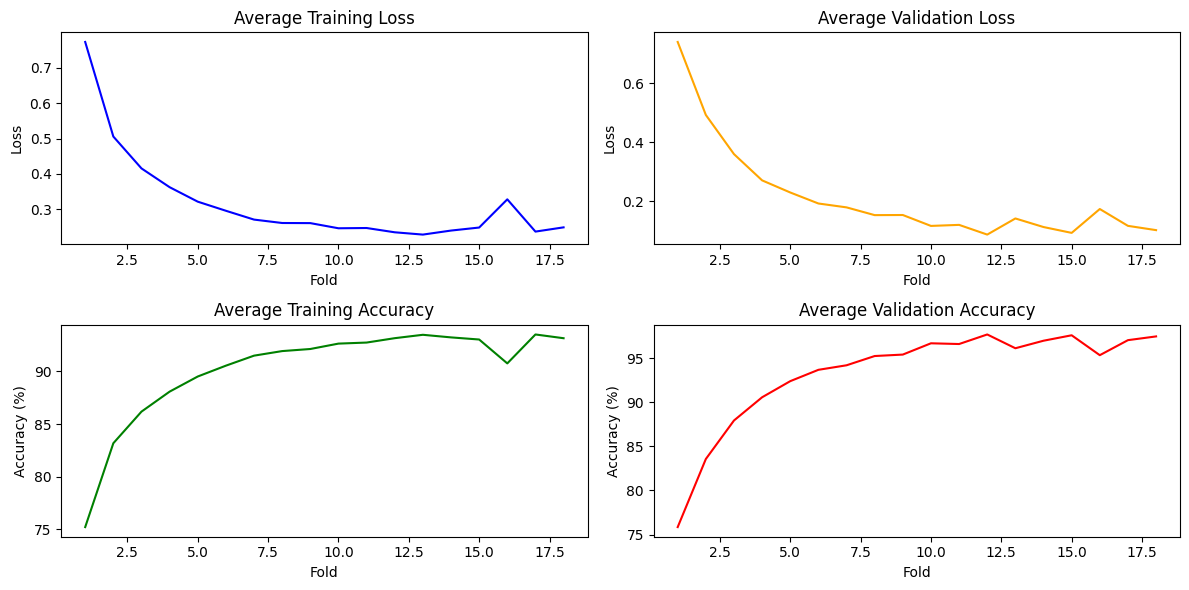

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, color='blue')
plt.title('Average Training Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')

plt.subplot(2, 2, 2)
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, color='orange')
plt.title('Average Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(range(1, len(all_train_accuracies) + 1), [acc * 100 for acc in all_train_accuracies], color='green')
plt.title('Average Training Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')

plt.subplot(2, 2, 4)
plt.plot(range(1, len(all_val_accuracies) + 1), [acc * 100 for acc in all_val_accuracies], color='red')
plt.title('Average Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

In [19]:
test_metrics = model.evaluate(images[data_test], labels[data_test])  
print("Test loss:", test_metrics[0])
print("Test accuracy:", test_metrics[1])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.9768 - loss: 0.1174
Test loss: 0.06917011737823486
Test accuracy: 0.9866666793823242


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (12).

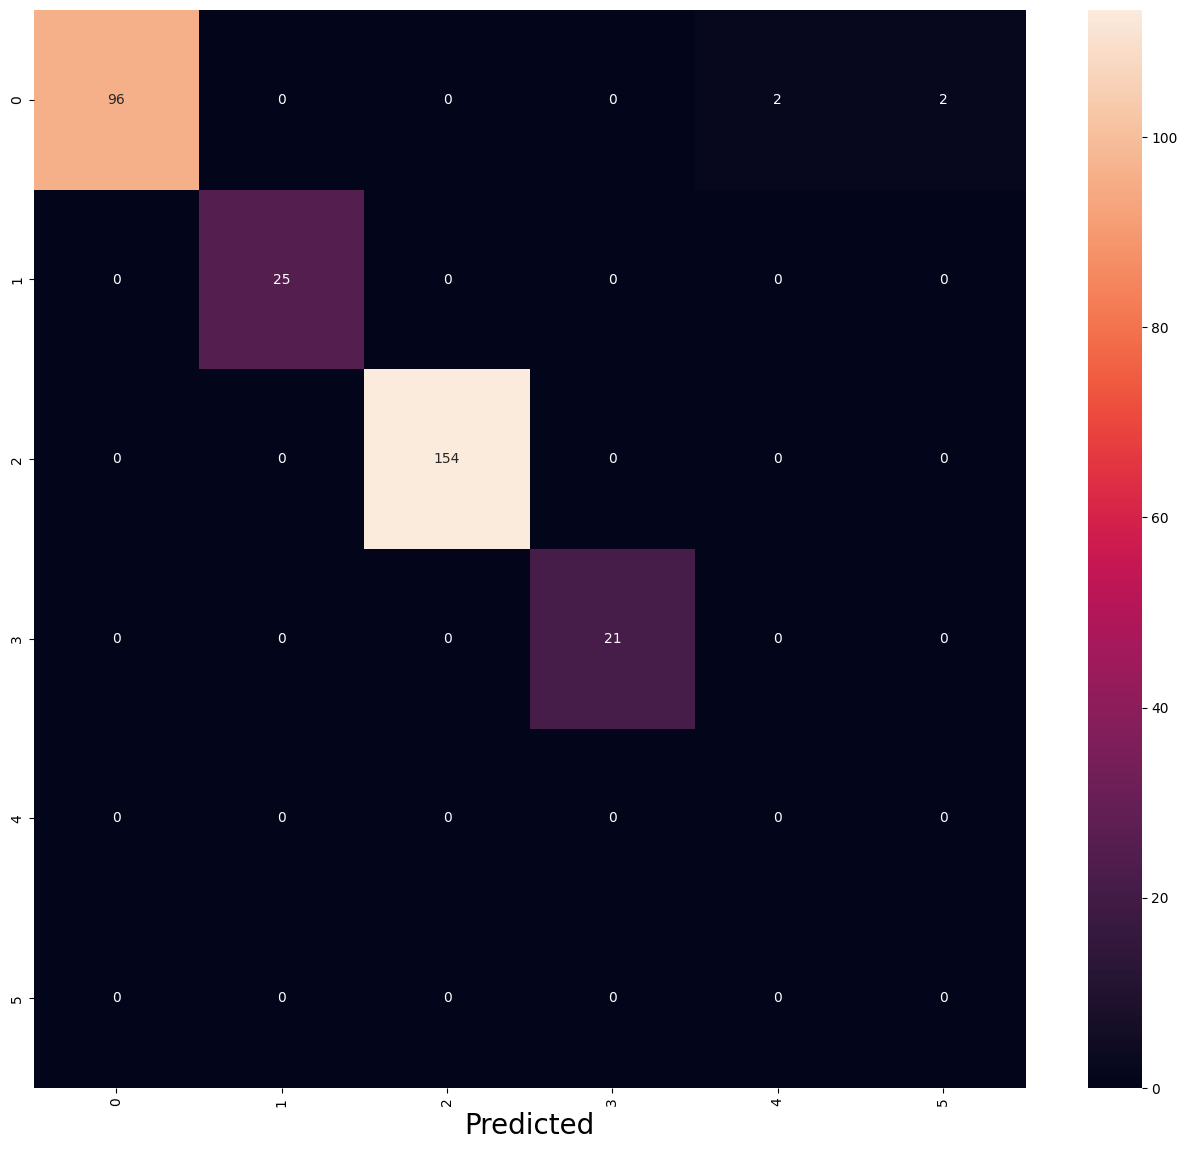

In [20]:
### Confusion Matrix
predictions = model.predict(images[data_test], steps=len(data_test), verbose=0)

y_pred = np.argmax(predictions, axis=-1)

cm = confusion_matrix(labels[data_test], y_pred)

## Get Class Labels
class_names = Classes

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True,robust=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.show()

In [ ]:
tp_and_fn = cm.sum(1)
tp_and_fp = cm.sum(0)
tp = cm.diagonal()
accuracy = cm.diagonal().sum()/cm.sum()
precision = tp / tp_and_fp
recall = tp / tp_and_fn
f1 = 2 * (precision * recall) / (precision + recall)
precision_avg=np.average(precision)
recall_avg=np.average(recall)
f1_avg=np.average(f1)

In [ ]:
# Creating a dictionary with the data
data = {
    'Metrics': ['Accuracy', 'Average Precision', 'Average Recall', 'Average F1 Score'],
    'Values': [accuracy, precision_avg, recall_avg, f1_avg]
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

In [ ]:
data = {
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)